In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tensorflow import keras
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
img_height=224; img_width=224; n_channel=3
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
from sklearn.model_selection import train_test_split

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df=pd.read_csv('/content/drive/MyDrive/labels.csv')
# df.head()
label_ID=df['breed'].apply(lambda x: x in ['beagle', 'chihuahua', 'doberman',
                                          'french_bulldog', 'golden_retriever',
                                          'malamute', 'pug', 'saint_bernard', 'scottish_deerhound','tibetan_mastiff'])
label=df[label_ID].reset_index(drop=True)

In [4]:
label.head()

,id,breed
0,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
1,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
2,008b1271ed1addaccf93783b39deab45,doberman
3,00a366d4b4a9bbb6c8a63126697b7656,golden_retriever
4,0100f55e4f0fe28f2c0465d3fc4b9897,golden_retriever


In [5]:
data_x=[]
for img_id in label['id']:
    pic=load_img("/content/drive/MyDrive/train/"+img_id+".jpg",target_size=(img_height,img_width))
    pic_array=img_to_array(pic)
    data_x.append(pic_array)
data_y=label['breed'].values
data_x=np.array(data_x)

In [6]:
data_x.shape

(841, 224, 224, 3)

In [7]:
from sklearn.preprocessing import OneHotEncoder
enc=OneHotEncoder()
data_y=(enc.fit_transform(data_y.reshape(-1,1))
        .toarray())
enc.categories_

[array(['beagle', 'chihuahua', 'doberman', 'french_bulldog',
        'golden_retriever', 'malamute', 'pug', 'saint_bernard',
        'scottish_deerhound', 'tibetan_mastiff'], dtype=object)]

In [8]:
data_y.shape

(841, 10)

Text(0.5, 1.0, 'golden_retriever')

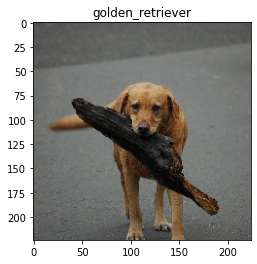

In [9]:

plt.imshow(data_x[0]/255.0)
plt.title(label.loc[0,'breed'])

### Model Building

In [10]:
def generate_model(img_height=img_height,img_width=img_width,n_channel=n_channel):
  resnet=ResNet50(include_top=False,
                  weights="imagenet",
                input_shape=(img_height,img_width,n_channel))
  resnet.trainable=False
  model = Sequential()
  model.add(resnet)
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(10, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
                          optimizer='Adam',
                          metrics=['accuracy'])
  return model

In [13]:
generate_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               51380736  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 74,973,578
Trainable params: 51,385,866
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
## Hyperprameter Tuning of no. of epochs and the batch size

def model_tuning(epoch,batch_size):
  

  xtrain,xvalid,ytrain,yvalid=train_test_split(data_x,data_y,test_size=0.2,random_state=5)
  
  model=generate_model()

  ##Data Augmentation
  datagen = ImageDataGenerator(shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               preprocessing_function=preprocess_input)
  datagen.fit(xtrain)
  
  
  model.fit(preprocess_input(xtrain),ytrain,batch_size=batch_size, epochs =epoch,verbose=0)
  model.fit(datagen.flow(xtrain, ytrain,batch_size=batch_size), epochs=epoch,verbose=0)
  
  # preprocess the input accoring to the requirements of ResNet50
  xtrain=preprocess_input(xtrain)
  train_pred = model.evaluate(x=xtrain,y=ytrain)

  xvalid=preprocess_input(xvalid)
  val_pred = model.evaluate(x=xvalid,y=yvalid)
  return train_pred[0],val_pred[0]

In [ ]:
batches=[16,32,64,128]
val_loss=[]
train_loss=[]
for batch in batches:
  val_loss.append([])
  train_loss.append([])
  print(f"Batch_size: {batch}")
  for ep in range(2,25,4):
    loss=model_tuning(ep,batch)
    # print(f"Training Loss:  {loss[0]} ||  Validation Loss:  {loss[1]}")
    train_loss[-1].append(loss[0])
    val_loss[-1].append(loss[1])

Batch_size: 16
6/6 [==============================] - 1s 52ms/step - loss: 5.3586 - accuracy: 0.9290
Batch_size: 32
6/6 [==============================] - 1s 52ms/step - loss: 1.7563 - accuracy: 0.9349
Batch_size: 64
6/6 [==============================] - 1s 52ms/step - loss: 1.4486 - accuracy: 0.9290
Batch_size: 128
6/6 [==============================] - 1s 52ms/step - loss: 0.7382 - accuracy: 0.9527


In [11]:
# plt.figure(figsize=[10,10])
style=['solid','dotted','dashed','dashdot']
# for i in range(4):
  # plt.plot(val_loss[i][1],label=f'Validation loss (batch_size {batches[i]})',linestyle=style[i])
  # plt.plot(train_loss[i][0],label='Training loss (batch_size {batches[i]})', linestyle=style[i])
# plt.xticks(range(0,6),range(2,25,4))
# plt.legend()
# plt.show()

**Final Model**

In [15]:
epoch=14
batch_size=32

x_train,x_valid,y_train,y_valid=train_test_split(data_x,data_y,test_size=0.2,random_state=10)

model=generate_model()

## Data Augmentation
datagen = ImageDataGenerator(shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               preprocessing_function=preprocess_input)
datagen.fit(x_train)

model.fit(datagen.flow(x_train, y_train,batch_size=batch_size), epochs=epoch,verbose=0)

# preprocess the input accoring to the requirements of ResNet50

x_valid=preprocess_input(x_valid)
val_pred = model.evaluate(x=x_valid,y=y_valid)

print(f"Accuracy on the Validation dataset is : {val_pred[1]*100}%")

## Save the model in an HDF5 file
# model.save("model.h5")


6/6 [==============================] - 1s 53ms/step - loss: 1.0006 - accuracy: 0.9349
Accuracy on the Validation dataset is : 93.49112510681152%


Dog breed is : golden_retriever
Prediction score : 1.0


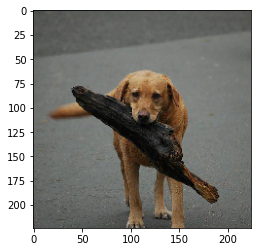

In [ ]:
from keras.models import load_model
breed=['beagle', 'chihuahua', 'doberman','french_bulldog', 
           'golden_retriever','malamute', 'pug', 'saint_bernard',
           'scottish_deerhound','tibetan_mastiff']

## Give image path as an input
img_path="/content/drive/MyDrive/train/0021f9ceb3235effd7fcde7f7538ed62.jpg"


## Preprocessing for new image
def preprocessing(img_path):
  image=load_img(img_path,target_size=(224,224,3))
  img_array=img_to_array(image)
  plt.imshow(img_array/255.0)
  img_array=np.expand_dims(img_array,axis=0)
  img_array=preprocess_input(img_array)
  return img_array

input_image=preprocessing(img_path)

# model=load_model("model.h5")
prediction=model.predict(input_image)
print(f"Dog breed is : {breed[np.argmax(prediction)]}")
print(f"Prediction score : {np.max(prediction)}")